## Lab 6

In [3]:
# %matplotlib widget
# Imports and setup
from pint import UnitRegistry
import math
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy

# Use pint
units = UnitRegistry()
units.default_format = "~P"
ureg = UnitRegistry()
ureg.setup_matplotlib()
Q_ = ureg.Quantity

In [67]:
#Output voltages
vo = {
    4: 3.986,
    7: 6.99,
    10: 9.98
}
Vg = 18
# Functions Used For Lab
def unpack_oscope(filepath):
    data = pd.read_csv(filepath)
    increment = float(data["Increment"][0])
    data = data.iloc[1: , :]
    data = data.astype(float)
    data["time"] = data["X"] * increment
    return data

def plot_vsh_vdr(voltages):
    start_tick = 0
    end_tick = -1
    
    for voltage in voltages: 
        data = unpack_oscope(f"../data/{voltage}V.csv")
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)  
        # Shunt voltage
        ax1.scatter(data["time"][start_tick:end_tick], data["CH1"][start_tick:end_tick], marker='.', s=0.5)
        # Drain Voltage
        ax2.scatter(data["time"][start_tick:end_tick], data["CH2"][start_tick:end_tick], marker='.', s=0.5)

        ax1.sharex(ax2)
        ax1.title.set_text("Shunt Voltage")
        ax2.title.set_text("Drain Voltage")
        ax2.set_xlabel("Time (s)")
        fig.suptitle(f"Shunt and Drain Voltage for V_out = {voltage}V") 

        plt.show()
        
def plot_freq(name, subtitle):
    start_tick = 0
    end_tick = -1
    
    data = unpack_oscope(f"../data/{name}.csv")
    fig, ax = plt.subplots()  
    # Drain Voltage
    ax.scatter(data["time"][start_tick:end_tick], data["CH2"][start_tick:end_tick], marker='.', s=0.5)

    ax.title.set_text("Drain Voltage")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Drain Voltage (V)")
    ax.set_title(f"Drain Ringing: {subtitle}") 

    plt.show()
    

def get_dvdr_dt(voltage, plot):
    start_tick = 4500-((voltage-4)*100)
    end_tick = 5500
    
    data = unpack_oscope(f"../data/{voltage}V.csv")
    # compute slope m and intercept b
    m, b = np.polyfit(data["time"][start_tick:end_tick],
                      data["CH1"][start_tick:end_tick], deg=1)

    if plot:
        # Plot
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)  
        # Shunt voltage
        ax1.scatter(data["time"][start_tick:end_tick], data["CH1"][start_tick:end_tick], marker='.')
        # Line of best fit
        # plot fitted I_PK = m*voltages + b
        ax1.axline(xy1=(0.95e-5, 0.95e-5*m +b), slope=m, color='r', label=f'dvdr_dt = {m:.2f}(vcomp) {b:+.2f}')
        # Drain Voltage
        ax2.scatter(data["time"][start_tick:end_tick], data["CH2"][start_tick:end_tick], marker='.')

        
        # Extras
        ax1.title.set_text(f"Gate Voltage @ V=V")
        ax2.title.set_text(f"Gate to Drain Voltage @ V=V")
        fig.suptitle(f"V =V") 
        plt.show()
    return m

def get_inductance(voltages):
    R = 0.05 # Ohms
    L = []
    Vg = 18 # V
    
    for voltage in voltages:
        didt = get_dvdr_dt(voltage, False) / R
        L.append(Vg / didt)
        
    return L, np.mean(L)

def get_D(voltage, plot, start_tick, end_tick, start_tick_D, end_tick_D):
    
    data = unpack_oscope(f"../data/{voltage}V.csv")
    Ts = data["time"][len(data["time"]) + end_tick] - data["time"][start_tick]
    
    Ta = data["time"][len(data["time"]) + end_tick_D] - data["time"][start_tick_D]
    D = Ta/Ts

    if plot:
        # Plot
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)  
        # Shunt voltage
        # ax1.scatter(data["time"][start_tick:end_tick], data["CH1"][start_tick:end_tick], marker='.', s=0.5)
        # Line of best fit
        # plot fitted I_PK = m*voltages + b
        # ax1.axline(xy1=(0.95e-5, 0.95e-5*m +b), slope=m, color='r', label=f'dvdr_dt = {m:.2f}(vcomp) {b:+.2f}')
        # Drain Voltage
        ax2.scatter(data["time"][start_tick_D:end_tick_D], data["CH2"][start_tick_D:end_tick_D], marker='.', s=0.5)

        
        # Extras
        ax1.title.set_text(f"Gate Voltage @ V=V")
        ax2.title.set_text(f"Gate to Drain Voltage @ V=V")
        fig.suptitle(f"V =V") 
        plt.show()
    return D

def get_turns_ratio(voltages, D, L_measured):
    a = []
    L_crit = 24.7 * 10**-6 #H
    alpha = L_measured/L_crit
    print(f"alpha = {alpha:.2f}")
    for i, voltage in enumerate(voltages):
        ratio = vo[voltage]/Vg
        a.append(ratio * (np.sqrt(alpha)-D[i])/D[i])
    return a

def get_peak_current(voltages):
    start_tick = 5000
    end_tick = 5800
    
    vsh_max = []
    
    for voltage in voltages:
        data = unpack_oscope(f"../data/{voltage}V.csv")
        # Shunt voltage
        vsh_max.append(max(data["CH1"][start_tick:end_tick]))
    print(f"The peak shunt voltages are {vsh_max} V, respectively. \n The peak currents are {20 * np.array(vsh_max)} A, respectively.")       
    return 20 * np.array(vsh_max)
        
        
        
    

Q1 & Q3:


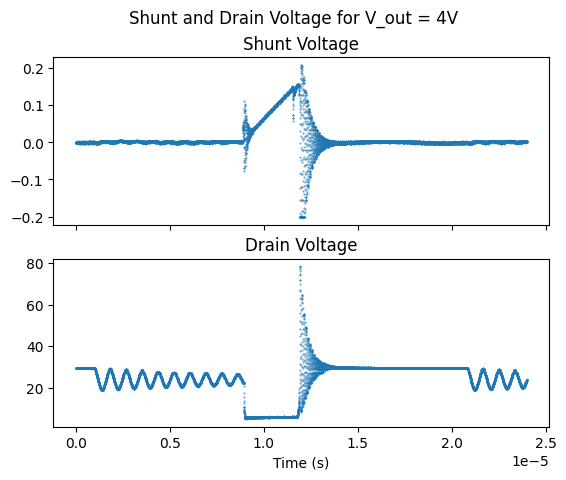

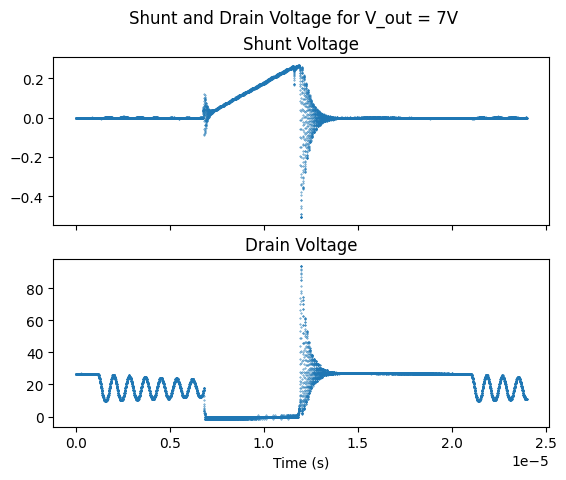

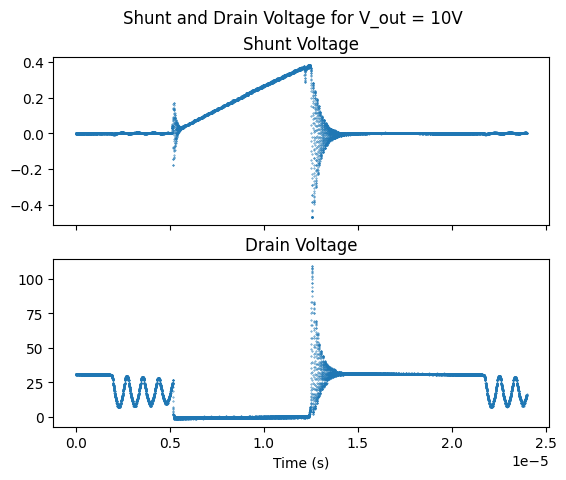

In [59]:
print("Q1 & Q3:")
plot_vsh_vdr([4, 7, 10])

Q2:
| **Nominal Output Voltage** | **Measured Output Voltage** | **Input Current** |
|----------------------------|-----------------------------|-------------------|
| 4 V                        | 3.986 V                     | 0.25 A            |
| 7 V                        | 6.99 V                      | 0.71 A            |
| 10 V                       | 9.98 V                      | 1.42 A            |

Q4:


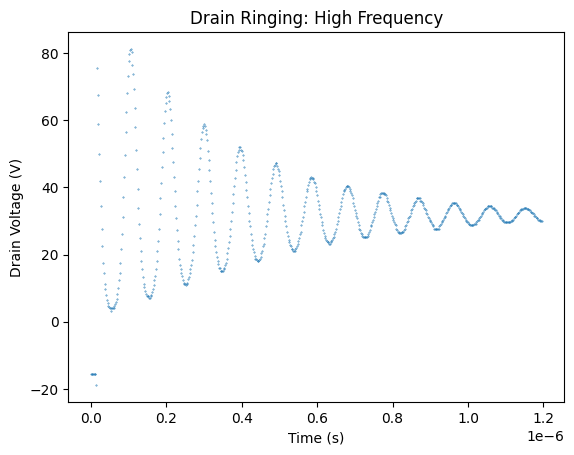

Q5:


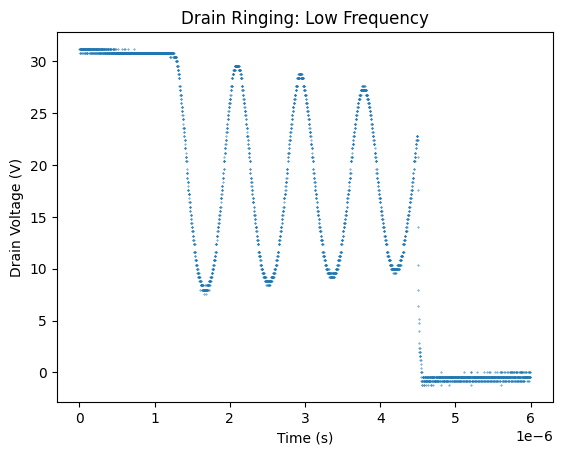

In [7]:
print("Q4:")
plot_freq("10V_high_freq", "High Frequency")

print("Q5:")
plot_freq("10V_low_freq", "Low Frequency")

In [91]:
inductances, avg_inductance = get_inductance([4, 7, 10])
print(f"Q6: The average inductance was {avg_inductance*10**6} uH, the raw values were {inductances} H based on shunt voltage slope")
D_10V = get_D(10, False, 900, -1150, 2610, -5800)
print(f"The duty cycle is {D_10V:.2f}.")
a = get_turns_ratio([10], [D_10V], avg_inductance)
print(f"The turns ratio is {a[0]:.3f}, based on the duty cycle. This value is off by about 16% from the expected value of {7/8} from manufacturing process.")



Q6: The average inductance was 17.27300676542448 uH, the raw values were [1.7475275664011628e-05, 1.7128259633696706e-05, 1.72154849985651e-05] H based on shunt voltage slope
The duty cycle is 0.36.
alpha = 0.70
The turns ratio is 0.731, based on the duty cycle. This value is off by about 16% from the expected value of 0.875 from manufacturing process.


Q8: While the design technically fell within specification for Q6, the discrepancy in turn ratio that is different than expected can be explained by an error made in the prelab. When deciding the number of turns and corresponding shim material for that number, we had a misreading of the graph prior to manufacture than resulted in one fewer turn for each winding, resulting in a lowered inductance. This issue was first observed (but we had not figured out the cause, thinking that it may have been a general tolerance issue) when the inductance measured using the LCR meter and found to be 17.34 uH, below our expected 19.85 uH which was used to calculate our turns ratio. This mistake would explain why our inductance was lower than desired, corresponding to a lower alpha, that corresponds to a lowered $a$ value. inductance.

Q9: Plots given above for ringing waveforms for Q4/Q5.

In [14]:
high_frequency = 5/(5.82e-7 - 1.05e-7) * units.hertz
high_frequency_delta = (1/5)*np.log(81/42.3)
high_frequency_damping_ratio = high_frequency_delta/np.sqrt(4*np.pi**2 + high_frequency_delta**2)
print("FET turn-off damped natural frequency:", high_frequency.to_compact())
print(f"FET turn-off damping ratio: {high_frequency_damping_ratio:.4f}")

low_frequency = 2/(3.77e-6 - 2.08e-6) * units.hertz
low_frequency_delta = (1/2)*np.log(29.41/27.38)
low_frequency_damping_ratio = low_frequency_delta/np.sqrt(4*np.pi**2 + low_frequency_delta**2)
print("Diode turn-off damped natural frequency:", low_frequency.to_compact())
print(f"Diode turn-off damping ratio: {low_frequency_damping_ratio:.5f}")


FET turn-off damped natural frequency: 10.482180293501047 MHz
FET turn-off damping ratio: 0.0207
Diode turn-off damped natural frequency: 1.183431952662722 MHz
Diode turn-off damping ratio: 0.00569


Based on the measurements, the electrical requirements are satisfied: 

The alpha value is 0.70, which just falls within the specification of being no lower than 70% based on measured inductance divided by calculated critical inductance. The measured duty cycle for a 10V output voltage is 36%, close to goal of 35% and far above the limit of 30%.



In [116]:
I_pk = get_peak_current([4, 7, 10])[2]
Io_pk = I_pk / a[0]
I_total = I_pk + Io_pk 

The peak shunt voltages are [0.15, 0.26, 0.348] V, respectively. 
 The peak currents are [3.   5.2  6.96] A, respectively.


Since we only care about the peak for calculating our flux density, we can use 6.96 A as the peak current through the primary winding. To get the second winding's peak current, we use the relationship between $I_p$ and $I_s$: $\,I_s = \frac{1}{a}I_p$. To get the total flux in the core, we need to add these currents together.

In [118]:
A_cmin = 59.1 * (units.mm)**2
turns = 15

phi_max = avg_inductance*(I_total) / turns
B_max = ((phi_max / A_cmin) * units.tesla * (units.meter)**2).to_compact()
print(f"Based on our measured currents, a-value, and inductance, our maximum flux density is {B_max:.1f}, 7% over the flux density limit.")

Based on our measured currents, a-value, and inductance, our maximum flux density is 321.2 millitesla, 7% over the flux density limit.


In [119]:
wire_area = 0.33 * (units.mm)**2 # 22 AWG
I_rms = math.sqrt(D_10V/3) * I_pk * units.amp
Io_rms = math.sqrt(D_10V/3) * Io_pk * units.amp
current_density = I_rms/wire_area
current_densityo = Io_rms/wire_area
print(f"We have a maximum current density of {current_density:.1f} for the primary winding and {current_densityo:.1f} for the secondary winding. \n This means that the current density may be very close to the limit for the secondary winding due to a higher measured duty cycle than was used to calculate minimum wire gauge.")


We have a maximum current density of 7.3 ampere / millimeter ** 2 for the primary winding and 10.0 ampere / millimeter ** 2 for the secondary winding. 
 This means that the current density may be very close to the limit for the secondary winding due to a higher measured duty cycle than was used to calculate minimum wire gauge.


## Independent Step

Recently, I've had a couple conversations with a friend who has worked/is returning to a company that works on power grid optimizations. I thought it would be interesting to learn more about how the power grid works as I have not had a chance to do so and it matches a  transformer lab.

Below are some of the things I learned while exploring this topic:

##### [Aluminum](https://www.seniorcare2share.com/what-materials-are-used-as-transmission-lines/#Which_metal_is_used_in_transmission_wires)

Most overhead transmission lines use aluminum as a conductor with steel to reinforce and allow for greater distance between supports. Copper is not used because the conductivity per weight is lower than aluminum.

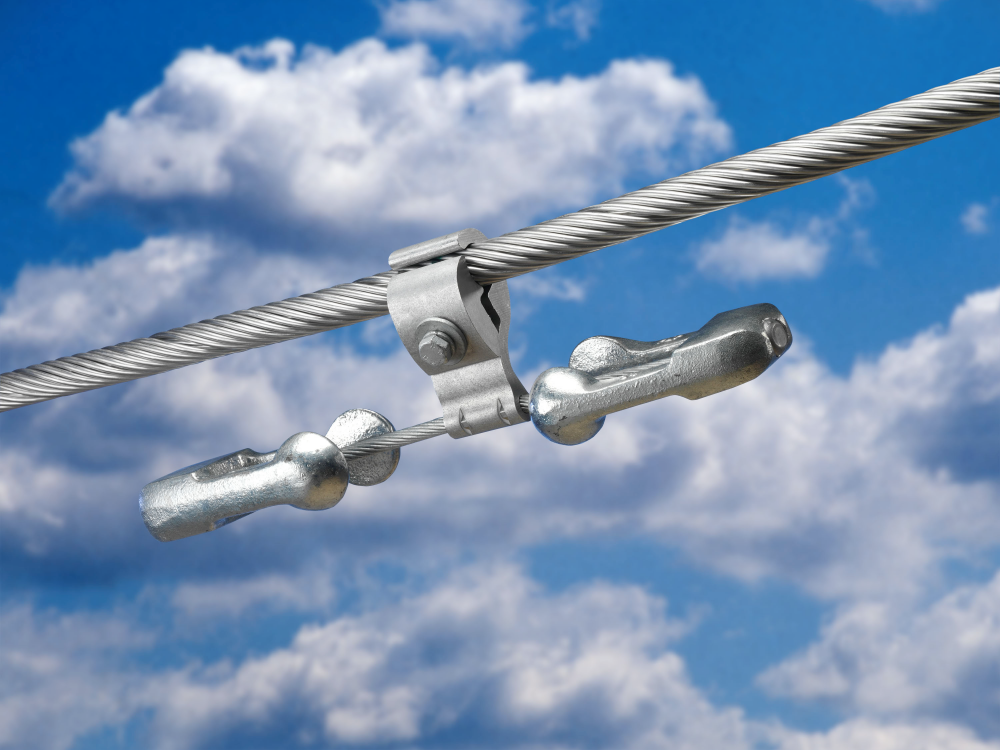

Mechanical dampers are necessary to reduce cable breakage due to the high winds for overhead transmission lines. I found this interesting because I initially read "dampers for transmission lines" and thought that it might be referring to some ringing that requires electrical damping. 

##### [High Voltage](https://peaksubstation.com/why-we-use-high-voltage-to-transmit-electrical-power/)
Since a higher voltage allows for a lower current with the same amount of power transmission, it will not require as much volume of conducting material. Lower current will also result in a lower voltage drop across the transmission line and less energy lost due to resistance (V=IR). [Typical voltages](https://signs.org/codes-regulations/federal-regulations/power-line-safety/) for power lines vary between 240 V to carry power into a home up to 765 kV for longer distance transmission. Between the longer distance lines, a power substation will drop the voltage down to less than 10 kV. By a home, a transformer drum will perform the final stepdown to 240 V. I thought it was cool to see diagrams of what the different components on power lines are, so next time that I see them, I will make note and try to identify them.

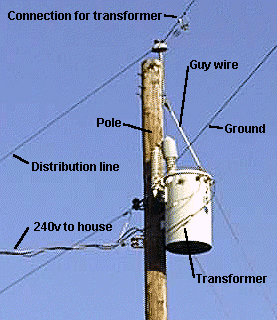

##### [Skin Effect](https://www.science.smith.edu/~jcardell/Courses/EGR220/ElecPwr_HSW.html#:~:text=Typical%20voltages%20for%20long%20distance,300%20miles%20(483%20km).)
Due to changing magnetic fields leading to eddy currents, power transmission lines deal with the skin effect. As a result, current density is highest towards the outer edge of the conductor, reducing the effective area. I also found it interesting that in some RF applications, hollow copper tubes are used instead of solid conductors to reduce required weight and material while maintaining a similar effective area.




